<a href="https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/04_Keras_Flowers_transfer_learning_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please select a GPU backend for this notebook. It uses pre-trained models in tf.keras.applications.* which are not TPU-compatible yet

## Imports

In [1]:
import os, math, json
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
#tf.enable_eager_execution()

Tensorflow version 1.13.1


In [0]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  if tf.executing_eagerly():
    # In eager mode, iterate in the Datset directly.
    for images, labels, one_hot_labels in dataset:
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      numpy_one_hot_labels = one_hot_labels.numpy()
      break;
      
  else: # In non-eager mode, must get the TF note that 
        # yields the nextitem and run it in a tf.Session.
    get_next_item = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as ses:
      (numpy_images,
       numpy_labels,
       numpy_one_hot_labels) = ses.run(get_next_item)

  return numpy_images, numpy_labels, numpy_one_hot_labels

def title_from_label_and_one_hot(label, one_hot_label):
  return label.decode("utf-8") + ' ' + str(one_hot_label)
def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(label.decode("utf-8"), str(correct), ', shoud be ' if not correct else '',
                              correct_label.decode("utf-8") if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels, one_hot_labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = title_from_label_and_one_hot(labels[i], one_hot_labels[i])
    subplot = display_one_flower(image, title, subplot)
    if subplot > 339:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.array(CLASSES)[np.argmax(predictions, axis=-1)]
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if subplot > 339:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Colab-only auth

In [0]:
# backend identification
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  auth.authenticate_user()  # not necessary to access a public bucket but you will probably want to access your private buckets too
  
HAS_COLAB_TPU = 'COLAB_TPU_ADDR' in os.environ
assert not HAS_COLAB_TPU, "Please select a GPU backend for this notebook. Pre-trained models in tf.keras.applications.* are not yet TPU-compatible"

## Configuration

In [5]:
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192/*.tfrec'
IMAGE_SIZE = [192, 192]

BATCH_SIZE = 64 # 128 works on GPU too but comes very close to the memory limit of the Colab GPU
EPOCHS = 10

VALIDATION_SPLIT = 0.19
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips'] # do not change, maps to the labels in the data (folder names)

# splitting data files between training and validation
filenames = tf.gfile.Glob(GCS_PATTERN)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 46 batches per training epoch and 10 batch(es) per validation run.


## Read images and labels from TFRecords

In [0]:
def read_tfrecord(example):
    features = {
        "image": tf.FixedLenFeature((), tf.string), # tf.string means byte string
        "label": tf.FixedLenFeature((), tf.string),
        "one_hot_label": tf.FixedLenFeature((), tf.string)
    }
    example = tf.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'])
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    one_hot_label = tf.io.decode_raw(example['one_hot_label'], out_type=tf.uint8) # 'decode' byte string into byte list
    one_hot_label = tf.cast(one_hot_label, tf.float32)  # convert one hot labels to floats
    one_hot_label = tf.reshape(one_hot_label, [5])  # explicit fixed size needed on TPU
    label = example['label']  # byte string
    return image, label, one_hot_label

def load_dataset(filenames):  
  # read from tfrecs
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=32)  # this will read from multiple GCS files in parallel
  dataset = records.map(read_tfrecord, num_parallel_calls=32)
  return dataset

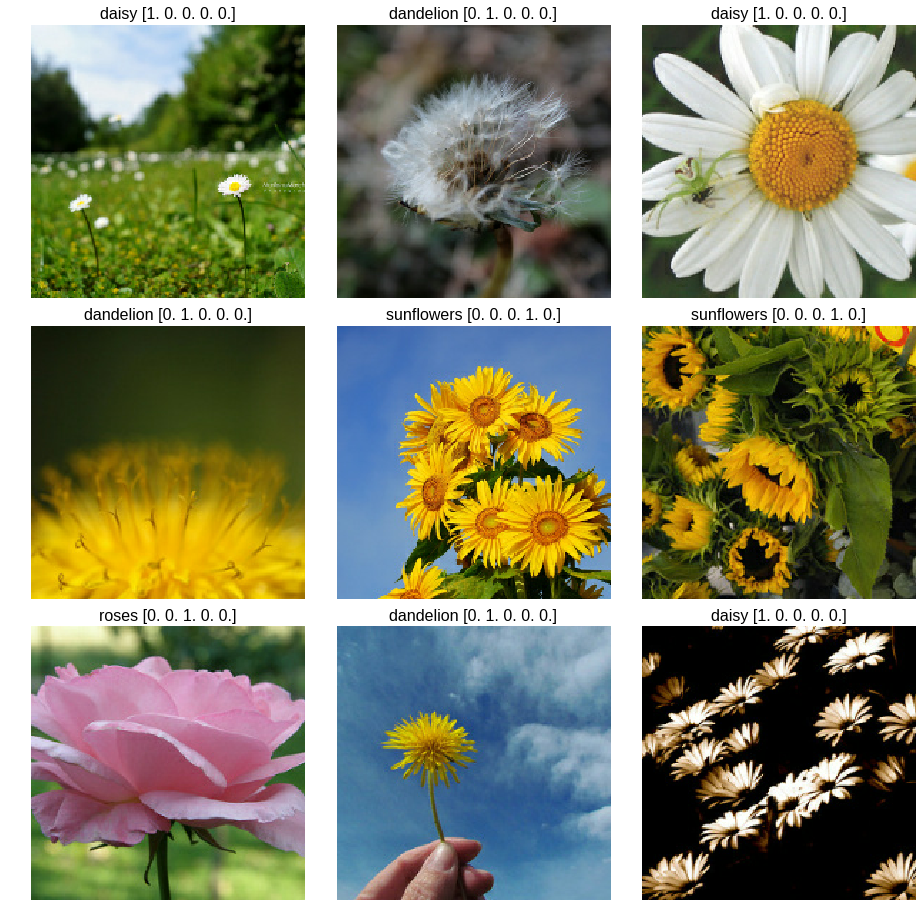

In [7]:
display_9_images_from_dataset(load_dataset(training_filenames))

## training and validation datasets

In [0]:
def features_and_targets(image, label, one_hot_label):
  feature = image
  target = one_hot_label
  return feature, target  # for training, a Keras model needs 2 items: features and targets

def get_batched_dataset(filenames):
  dataset = load_dataset(filenames)
  dataset = dataset.map(features_and_targets, num_parallel_calls=32)
  dataset = dataset.cache() # This dataset fits in RAM
  dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # drop_remainder needed on TPU
  dataset = dataset.prefetch(-1) # prefetch next batch while training (-1: autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames)
validation_dataset = get_batched_dataset(validation_filenames)

## Model [WORK REQUIRED]
1. Write a [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential) model yourlsef. The constructor takes a list of layers. What layers ? Since we have no idea yet, try this:
 * use a pretrained model loaded from tf.keras.applications. Remove its final softmax layer with `include_top=False` (code below). You can now use it as a "layer".
 * add your own [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer with softmax activation and the correct number of units (hint: we are calssifying flowers into 5 classes).
 * between the two, tensor shapes do not match. The dense layer expects a vector input (1D). Try [`tf.keras.layers.Flatten()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) or [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D)
 * add the last bits and pieces with [model.compile()](https://www.tensorflow.org/api_docs/python/tf/keras/models/Model#compile). For a classifier, you need 'categorical_crossentropy' loss, 'accuracy' in metrics and you can use the 'adam' optimizer.
1. You can try adding a second dense layer. Use 'relu' activation on all dense layers but the last which must be 'softmax'. An additional layer ads trainable weights. It is unlikely to do much good here though, because our dataset is too small.
 
This technique is called "transfer learning". The pretrained model has been trained on a different dataset but its layers have still learned to recognize bits and pieces of images that can be useful for flowers. You are retraining the last layer only, the pretrained weights are frozen. With far fewer weights to adjust, it works with less data.

In [9]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False

### QUESTION 1.
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer=tf.train.AdamOptimizer(),
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# little wrinkle: in eager mode, only tf.train.*Optimizer optimizers will work in model.compile,
# not strings like 'adam' which map to Keras optimizers. Unfortunately the TF optimizers do not
# support Keras learning rate schedules (tf.keras.callbacks.LearningRateScheduler).
# A fix is in the works.

Instructions for updating:
Colocations handled automatically by placer.
9412608/9406464 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 46080)             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 230405    
Total params: 2,488,389
Trainable params: 230,405
Non-trainable params: 2,257,984
_________________________________________________________________


## Training

In [10]:
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=validation_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
46/46 [==============================] - 19s 415ms/step - loss: 1.7069 - acc: 0.7347 - val_loss: 2.9967 - val_acc: 0.6609
Epoch 2/10
46/46 [==============================] - 7s 154ms/step - loss: 0.4631 - acc: 0.9314 - val_loss: 2.3788 - val_acc: 0.7250
Epoch 3/10
46/46 [==============================] - 7s 155ms/step - loss: 0.1826 - acc: 0.9728 - val_loss: 1.8063 - val_acc: 0.7672
Epoch 4/10
46/46 [==============================] - 7s 153ms/step - loss: 0.1152 - acc: 0.9854 - val_loss: 1.5070 - val_acc: 0.8047
Epoch 5/10
46/46 [==============================] - 7s 153ms/step - loss: 0.1074 - acc: 0.9847 - val_loss: 1.9078 - val_acc: 0.7844
Epoch 6/10
46/46 [==============================] - 7s 152ms/step - loss: 0.1076 - acc: 0.9857 - val_loss: 1.7708 - val_acc: 0.7969
Epoch 7/10
46/46 [==============================] - 7s 153ms/step - loss: 0.0752 - acc: 0.9918 - val_loss: 1.5862 - val_acc: 0.8125
Epoch 8/10
46/46 [=========

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


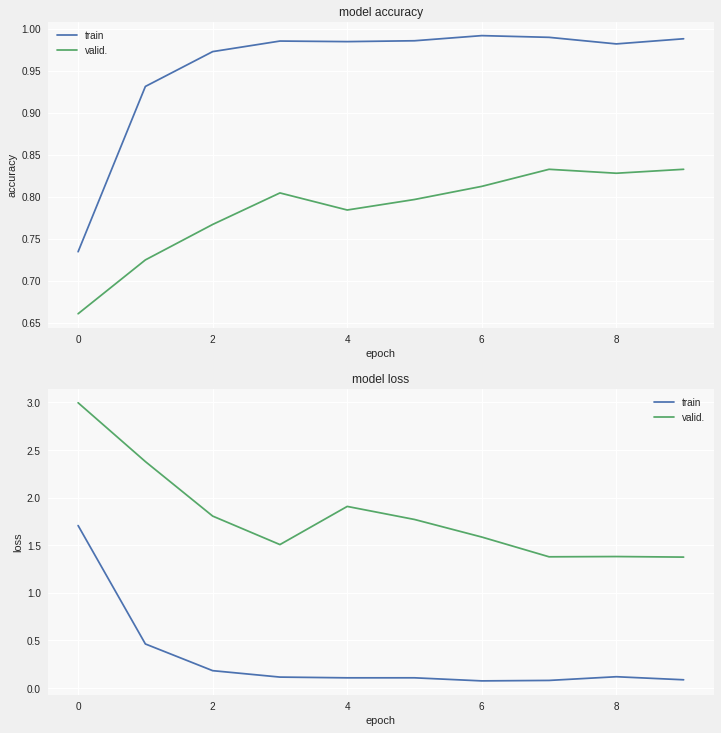

In [11]:
print(history.history.keys())
display_training_curves(history.history['acc'], history.history['val_acc'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Predictions

In [12]:
# random input: execute multiple times to change results
flowers, labels, _ = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(300)), 9)

predictions = model.predict(flowers, steps=1)
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

[b'sunflowers', b'sunflowers', b'daisy', b'roses', b'sunflowers', b'dandelion', b'sunflowers', b'sunflowers', b'daisy']


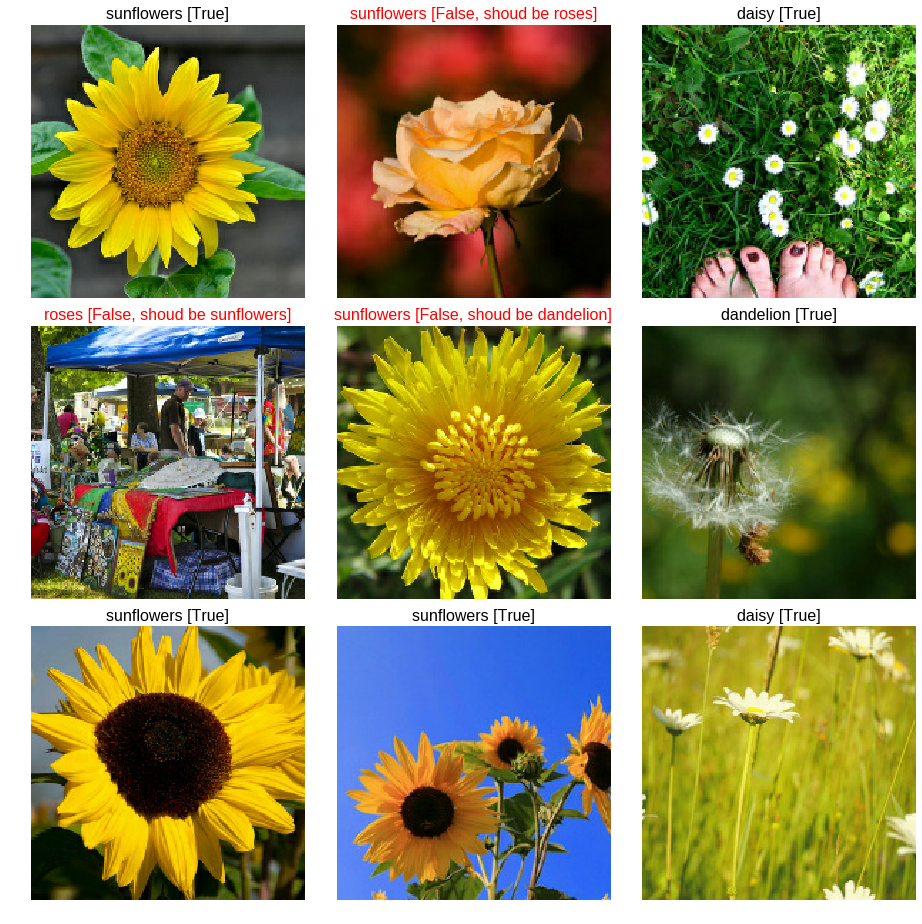

In [13]:
display_9_images_with_predictions(flowers, predictions, labels)